<a href="https://colab.research.google.com/github/joshuaalpuerto/ML-guide/blob/main/Micrograd_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [74]:
# This is a sample function to plot our data.
# We will use this also an example so we can approximate the slope,
# which in this context represents how much the value of the function changes as the variable a changes.
def f(x):
  return 3*x**2 - 4*x + 5

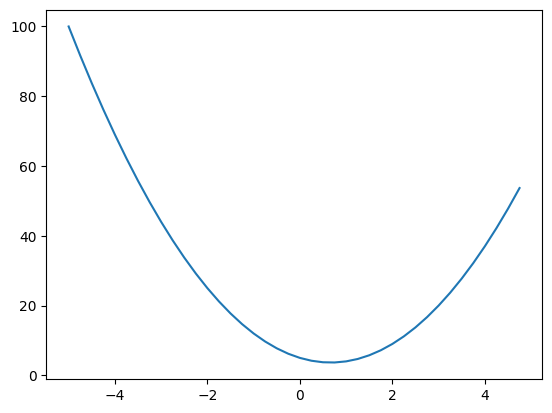

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [75]:
h = 0.000001
x = -3
P1 = f(x)
P2 = f(x + h)

## Lets break this down
## Note that we wanted to calculate the slope
## Remember that x (value in x-axis) and f(x) (value in y-axis)
## X1 = value of x and Y1 = value of P1(f(x)).
## X2 = value of x+h AND Y2 = value of P2(f(x+h)).
## What it means is P1(Y1) and P2(Y2) represent the values of your function at two different x-axis points respectively X1 and X2.
## The difference P2 - P1 is how much the output (or y-value) changes when `x` (the input or x-value) changes by `x + h`.
## So the slope is the rate of change of the function for a small change in `x`.
## Formula slope = `changes in y / changes in x`
## Note if you want to visualize, check here - https://www.mathsisfun.com/definitions/slope.html
slope = (P2 - P1)/h

## Why do want to compute slope in context of derivatives?
## The slope of the tangent to a curve at this point is known as the derivative of the function(mathematical way/formula) with respect to x
## And it tells you the rate of change of the output(loss etc.) respect to a parameters.
## If the slope is positive, it means increasing the parameter makes the output grow (you’re moving uphill),
## and if it's negative, decreasing the parameter makes the output less (it could go to negative.)
## Now in context of NN, if the slope is negative, increasing the parameter (values are going to the right)
## It means you are going downhill. Check this note - https://www.notion.so/Neural-networks-Zero-to-Hero-1285a706faf2807f928dc38cf8f90866?pvs=4#12e5a706faf2801d93a4d2f98db7f705
##
## Also you will notice when we apply differentiation to (`3*x**2 - 4*x + 5`) is the same value as `slope`
## Note that this is simplified way of getting the derivative/slope
derivative = (6*x) - 4

print('derivative', derivative)
print('slope', slope)

derivative -22
slope -21.999997002808414


In [6]:
# les get more complex
# This is complex because we have multiple variables.
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# Think of this inputs as
# a = input
# b = weights
# c = bias
a = 2.0
b = -3.0
c = 10.0

# Given the value of d1
# What is the slope if we change the value of one of the parameters.
# Note without tightly couple with ML, we can think of this problem more of optimization.
# How fast we can find the local minima with changes to our parameters
d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 3.999699999999999
slope -3.000000000010772


In [66]:
## Note that the value class here is very basic.
## Check the github repo for more complete methods.
## https://github.com/karpathy/micrograd/blob/master/micrograd/engine.py
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    ## So we can add scalar value
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data + other.data, (self, other), '+')

    # Have a closure function so when we d backprop we know how to apply
    # Gradient to the local derivatives
    # e.g. x = a(self.grad) + b(other.grad)
    def _backward():
      # why do need += here?
      # Because if we use the variables multiple times gradients needs to be accumlated.
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __sub__(self, other): # self - other
    ## Not used in expression but just to find loss
    return self + (-other)

  def __mul__(self, other):
    ## So we can add scalar value
    other = other if isinstance(other, Value) else Value(other)

    out = Value(self.data * other.data, (self, other), '*')

    # Have a closure function so when we d backprop we know how to apply
    # Gradient to the local derivatives
    # e.g. x = a(self.grad) * b(other.grad)
    def _backward():
      # why do need += here?
      # Because if we use the variables multiple times gradients needs to be accumlated.
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        ## Using power rule
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  ## We need this __r*__ because some values are just scalar value
  def __rmul__(self, other): # other * self
    return self * other

  def __radd__(self, other): # other + self
    return self + other

  def __rsub__(self, other): # other - self
    return self - other

  ## For the purpose of this example we have composite funcion here (a non atomic operator)
  ## What is important is we know how to compute the local deriviative.
  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    # Gradient to itself
    # e.g. o = x.tanh()
    def _backward():
      # why do need += here?
      # Because if we use the variables multiple times gradients needs to be accumlated.
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    ## Backpropagation needs to walk to each node backwards.
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    ## Why self.grad = 1?
    ## Because the right most output will always have grad 1.
    ## Note that we should always do .backward first to the right most output node.
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [24]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [25]:
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')
e = a*b; e.label = 'e'
d = e + c; d.label = 'd'
f = Value(-2.0, label='f')
L = d * f; L.label = 'L'
L

Value(data=-8.0)

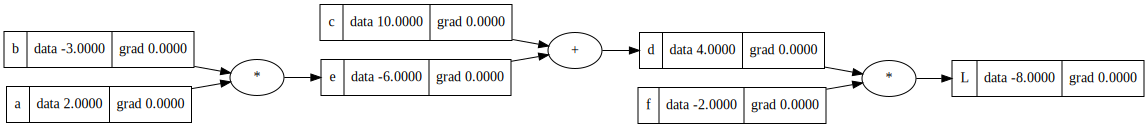

In [26]:
# When you look at the graph just think about it as a single forward pass where `L` is the output.
# You will notice that each neurons(letters) output(weights) contributes tothe output of `L` which in context of backpropogation
# we wanted to identify what changes we should apply to those neurons(letters) output(weights) to achieve our output goal.
# L = Loss, and we are interested in the derivatives of each letter w.r.t to L (to minimize L)
#
# Why do we call them gradients instead of derivatives if they are derived from derivatives after all? (why do we need distinction?)
# - **Derivatives** refer to the rate of change of a function with respect to a single variable. In simple terms, a derivative gives us the “slope” at a specific point. So, if we have a loss function `L` that depends on a single parameter `w`, the **derivative** `dL/dw` tells us how `L` changes as `w` changes.
# - **Gradients**, however, are the generalization of derivatives to functions with multiple inputs. In deep learning, the loss function depends on **many parameters** (weights and biases across all layers). The **gradient** is the vector of all partial derivatives of the loss with respect to each parameter. So, if we have parameters `w1`, `w2`, ..., `wn`, the gradient of `L` is the vector `[dL/dw1, dL/dw2, ..., dL/dwn]`.
# - **Why the distinction?** We use “gradient” instead of “derivative” because we’re typically dealing with **multivariable functions** in neural networks. Each weight and bias in the network is an independent variable, so the gradient captures the combined rate of change of the loss with respect to all parameters at once. This is what allows us to know how to adjust every parameter in the network simultaneously to reduce the loss.
#
# Why we need local derivative?
# Because you can't compute the derivative of inner parameters directly from the final output.
# E.g.  we want to compute dL/dc (derivative of `L` w.r.t `c`)
# We need find first the local derivative dd/dc (derivative of `d` w.r.t `c`) then multiply it with dL/dd (derivative of `L` w.r.t `d`)
# More info - https://www.notion.so/Neural-Networks-from-Scratch-541470b7533542e1aefe69c29509c2e9?pvs=4#12b5a706faf28060b5f1f05432a6df1f

draw_dot(L)

In [13]:
# Here we are going to check the derivative of L w.r.t (any letter)
# Note that we have this function as staging area
# So we don't mess with global variables.


# This is computing derivative that direct dependency of L
def simple_derivative():
  # Treat h as learning raate.
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  # What is the derivative of L w.r.t d (because we are adding the h to d)
  d.data += h
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print('simple_derivative', (L2 - L1)/h)

simple_derivative()

## What if we want to know the deriviative of L w.r.t to c (not direct dependency of L?)
## We will apply **Chain rule**
## So if we want to compute dL/dc?
## dL / dd = 2.0 (we compute this using derivative)
## dd / dc = 1
## Then: dL / dc = (dd / dc) * (dL / dd)
## more info here: https://www.notion.so/Neural-networks-Zero-to-Hero-1285a706faf2807f928dc38cf8f90866?pvs=4#12b5a706faf280508e68e789da112788
def derivative_innner_layer():
  # Treat h as learning raate.
  h = 0.001

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  # what is the derivative of d w.r.t to c
  c.data += h
  e = a*b; e.label = 'e'
  # You will notice thatthe derivative of L w.r.t d == -2.0(gradient)
  # where what `+` does is we just use the gradientof D and use it to c and e.
  # you can confirm this through differentiation.
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print('derivative_innner_layer', (L2 - L1)/h)

derivative_innner_layer()

simple_derivative -2.000000000000668
derivative_innner_layer -1.9999999999988916


In [28]:
## Lets calculate all the gradients.
L.backward()

## Now we can see adjust the parameters and see how it affects the final output `L`
## NOTE:
## We use +0.01 so we can go to opposite direction as our `L` is already negative (move to 0).
## In actual NN setup, we use negative value (-0.01).
## Why? Because our loss (MSE, etc..) is always be positive.
## The negative sign ensures that the update moves in the direction that decreases the loss function(move to 0).
## This is because the gradient points in the direction of the steepest increase of the loss function,
## and moving in the opposite direction decreases the loss.
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b; e.label = 'e';
d = e + c; e.label = 'd';
L = d * f; L.label = 'L';

print(L.data)


-10.229942851072135


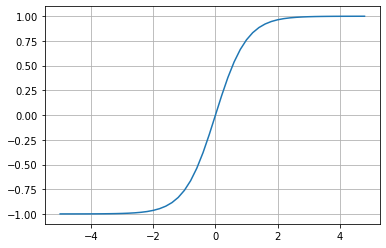

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [18]:
## Let's see this in Neural network settings
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

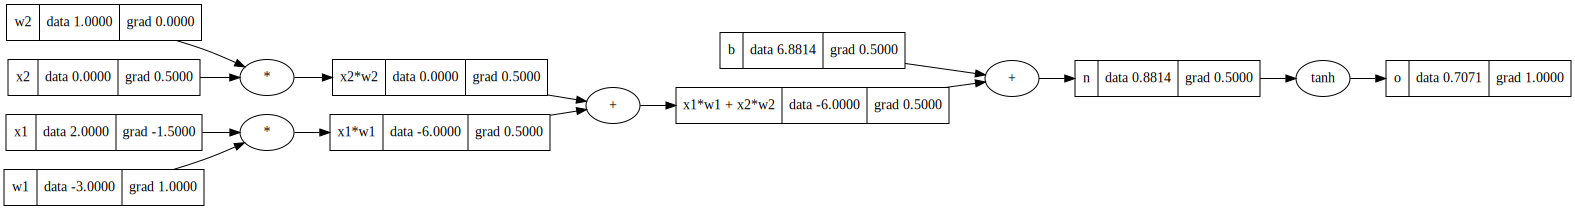

In [21]:
# Apply backwprop
o.backward()

draw_dot(o)

In [22]:
# using pytorch
import torch

x1 = torch.Tensor([2.0]).double()    ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()    ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()   ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()    ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True

n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
# Notice that the grads above is similar.
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [30]:
import random

## Reprocibility
random.seed(42)

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    # We are just listing all parameter under this layer
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    # We are just listing all parameter under this deep network
    return [p for layer in self.layers for p in layer.parameters()]

In [67]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets

In [71]:
n = MLP(3, [4, 4, 1])

# training
for k in range(20):

  # forward pass
  ypred = [n(x) for x in xs]
  ## Compute loss using MSE
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    ## zero_grad - reset our gradsbefore recalculating grads
    p.grad = 0.0
  loss.backward()

  ## Because our loss (MSE, etc..) will always be positive.
  ## The negative sign(-0.1) ensures that the update moves in the direction that decreases the loss function.
  ## This is because the gradient points in the direction of the steepest increase of the loss function,
  ## and moving in the opposite direction decreases the loss.
  ## NOTE that this is a simplified version of the stochastic gradient descent (SGD) update rule
  ## w_new = w_old - (lr * dL/dw)
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(k, loss.data)

0 5.144503428906164
1 2.7438297276610353
2 1.490047522990562
3 0.8996036893866574
4 0.5817581528806512
5 0.40515848220554673
6 0.29646916364526366
7 0.2247814026686713
8 0.17523418196201088
9 0.1398112199262979
10 0.11381257721764572
11 0.09431144901743184
12 0.07940400939168697
13 0.06781155004894017
14 0.058654015285354556
15 0.05131374194015728
16 0.04534994812948324
17 0.040443360840271336
18 0.03635950643397007
19 0.03292392426310706


In [72]:
ypred

[Value(data=0.9343847153766986),
 Value(data=-0.9164365774916801),
 Value(data=-0.8879001834319492),
 Value(data=0.9047668952988742)]